# Measuring creativity

Once you've trained a pass selection, pass outcome and pass value model, they can be combined to measure the creativity of a pass.

In [1]:
from pathlib import Path
from functools import partial

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import mlflow
from scipy.ndimage import zoom

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from unxpass.databases import SQLiteDatabase
from unxpass.datasets import PassesDataset
from unxpass.components import pass_selection, pass_value, pass_success
from unxpass.components.utils import load_model
from unxpass.visualization import plot_action
from unxpass.ratings import CreativeDecisionRating

/cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
plt_settings = {"cmap": "magma", "vmin": 0, "vmax": 1, "interpolation": "bilinear"}

## Load dataset

In [5]:
STORES_FP = Path("../stores")

db = SQLiteDatabase(STORES_FP / "database.sql")

dataset_test = partial(PassesDataset, path=STORES_FP / "datasets" / "euro2020" / "test")

In [6]:
# Select an example pass
SAMPLE = (3795506, 4)

,,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,bodypart_id,type_id,result_id,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360
3795506,4,7cc5e22d-caff-46b1-8adf-fb1f3e3bdc1e,1,5.0,914,11514,33.705882,9.98481,21.088235,28.663291,5,0,1,914.0,From Kick Off,0,"{'pass': {'recipient': {'id': 7173, 'name': 'L...","[[53.155008354104645, 0.0], [32.85311409175197...",1,"[{'teammate': True, 'actor': False, 'keeper': ..."


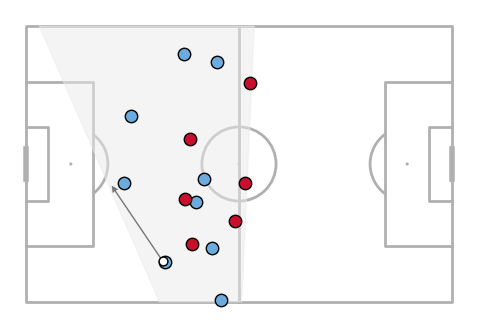

In [7]:
# Show the selected example
ex_action = db.actions(game_id=SAMPLE[0]).loc[SAMPLE]
display(ex_action.to_frame().T)

fig, ax = plt.subplots(figsize=(6,4))
ax = plot_action(ex_action, ax=ax)
plt.show()

Note that this is probably not a creative pass. It looks like a typical pass and it is not very useful.

## Load models

### Pass selection

In [8]:
model_pass_selection = pass_selection.SoccerMapComponent(
    model=mlflow.pytorch.load_model(
        #'runs:/8a4c034f5d2046039e95393c06fe8969/model', map_location='cpu'
        'runs:/788ec5a232af46e59ac984d50ecfc1d5/model', map_location='cpu'
    )
)
model_pass_selection.test(dataset_test)

[07/17/23 11:59:08] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=107425;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=584300;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

{'log_loss': 5.850149801707092,
 'brier': 0.9885089131955397,
 'acc': 0.5454545454545454}

In [9]:
surface_pass_selection = model_pass_selection.predict_surface(dataset_test)

[07/17/23 12:00:42] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=407289;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=492629;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [00:08<00:00, 66.29it/s]


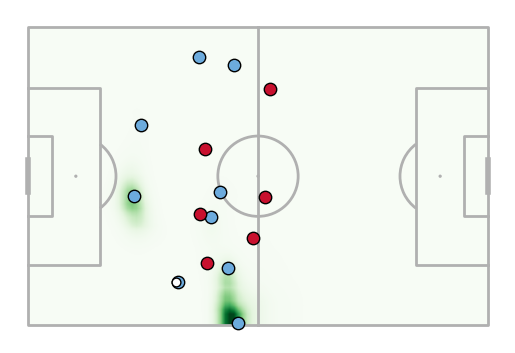

In [12]:
fig, ax = plt.subplots()
ax = plot_action(
    ex_action, surface=surface_pass_selection[SAMPLE[0]][SAMPLE[1]], 
    show_visible_area=False, show_action=False,
    ax=ax, surface_kwargs={**plt_settings, "vmin": None, "vmax": None, "cmap": "Greens"}
)
plt.show()

### Pass success

In [13]:
model_pass_success = load_model('runs:/f0d0458824324fbbb257550bf09d924a/component')
model_pass_success.test(dataset_test)

[07/17/23 12:03:02] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=965482;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=32931;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

{'precision': 0.9617486338797814,
 'recall': 0.9795918367346939,
 'f1': 0.9705882352941176,
 'log_loss': 0.1561886008002896,
 'brier': 0.045388154333901594,
 'roc_auc': 0.9426210153482881}

### Pass value

In [14]:
model_pass_value = load_model(
    'runs:/f4f4efb5f0534f03a1d513141e06c962/component',
)
model_pass_value.test(dataset_test)

[07/17/23 12:03:03] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=602946;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=387168;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

[07/17/23 12:03:04] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=117996;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=727981;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

{'offensive': {'brier': 0.00913297383356254,
  'log_loss': 0.04838631026974633,
  'roc_auc': 0.8361678004535148},
 'defensive': {'brier': 0.0016870561834701665,
  'log_loss': 0.01366890293054475,
  'roc_auc': 0.9763912310286678}}

## Value creativity

In [15]:
rater = CreativeDecisionRating(
    pass_selection_component=model_pass_selection,
    pass_success_component=model_pass_success,
    pass_value_component=model_pass_value
)

In [16]:
df_ratings = rater.rate(db, dataset_test)
df_ratings.loc[SAMPLE]

                    INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=901559;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=793459;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

                    INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=253749;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=617024;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 594/594 [00:09<00:00, 64.72it/s]


[07/17/23 12:03:14] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=248130;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=745630;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

[07/17/23 12:03:50] INFO     Loading dataset from ../stores/datasets/euro2020/test                  ]8;id=102762;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=315789;file:///cw/dtaijupiter/NoCsBack/dtai/pieterr/Projects/soccer-unxpass-public/.venv/lib/python3.9/site-packages/lightning_utilities/core/rank_zero.py#32\32]8;;\

start_x                  33.705882
start_y                    9.98481
true_end_x               21.088235
true_end_y               28.663291
success                       True
typical_end_x              45.9375
typical_end_y                  0.5
true_p_success            0.998893
typical_p_success         0.992608
true_value_success        0.002047
typical_value_success     0.002685
true_value_fail          -0.022069
typical_value_fail        -0.00076
CDR                      -0.000651
Name: (3795506, 4), dtype: object